In [1]:
import os
import sys
sys.path.append(os.path.abspath('..'))
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

/home/marsdenlab/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
#Get MNIST data from tensorflow
dataset = tf.contrib.learn.datasets.load_dataset('mnist')
X_train = dataset.train.images

X_test = dataset.test.images

print(X_train.shape, X_test.shape)

Instructions for updating:
Please use tf.data.
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST-data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST-data/train-labels-idx1-ubyte.gz
Extracting MNIST-data/t10k-images-idx3-ubyte.gz
Extracting MNIST-data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
(55000, 784) (10000, 784)


In [3]:
W = int(np.sqrt(X_train.shape[1]))

X_im_train = X_train.reshape((-1,W,W,1))
X_im_test  = X_test.reshape((-1,W,W,1))

print(X_im_train.shape, X_im_test.shape)

(55000, 28, 28, 1) (10000, 28, 28, 1)


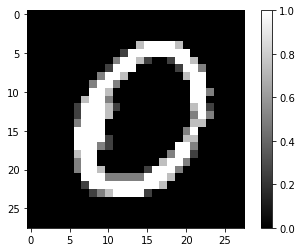

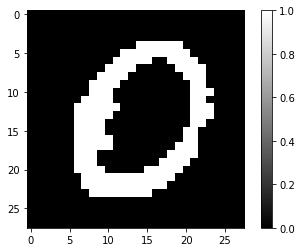

In [4]:
index = np.random.randint(X_im_train.shape[0])

x_thresh = (X_im_train[index,:,:,0]>0).astype(int)

plt.figure()
plt.imshow(X_im_train[index,:,:,0], cmap='gray')
plt.colorbar()
plt.show()
plt.close()

plt.figure()
plt.imshow(x_thresh, cmap='gray')
plt.colorbar()
plt.show()
plt.close()

In [5]:
#create position matrix for point sampling
POS_MAT = np.zeros((W,W,2))
dx      = 1.0/W

for i in range(0,W):
    for j in range(0,W):
        POS_MAT[i,j,0] = (i+0.5)*dx
        POS_MAT[i,j,1] = (j+0.5)*dx

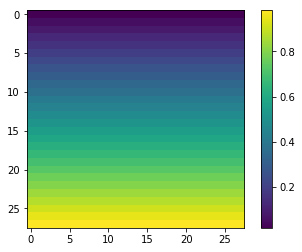

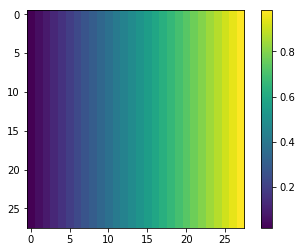

In [6]:
plt.figure()
plt.imshow(POS_MAT[:,:,0])
plt.colorbar()
plt.show()
plt.close()

plt.figure()
plt.imshow(POS_MAT[:,:,1])
plt.colorbar()
plt.show()
plt.close()

In [7]:
def get_point_cloud(X,POS_MAT):
    x_bool = (X>0)

    pos_x = POS_MAT[x_bool,0]
    pos_y = POS_MAT[x_bool,1]

    pos_x_out = POS_MAT[~x_bool,0]
    pos_y_out = POS_MAT[~x_bool,1]
    
    return (pos_x, pos_y, pos_x_out, pos_y_out)

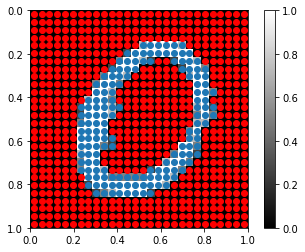

In [8]:
pos_x, pos_y, pos_x_out, pos_y_out = get_point_cloud(X_im_train[index,:,:,0],POS_MAT)

plt.figure()
plt.imshow(X_im_train[index,:,:,0], extent=[0,1,1,0], cmap='gray')
plt.colorbar()
plt.scatter(pos_y,pos_x)
plt.scatter(pos_y_out,pos_x_out, color='r')
plt.show()
plt.close()

In [9]:
from modules.layers import conv2D, fullyConnected

def get_batch(X,N,n=32):
    inds = np.random.choice(range(N),size=n, replace=False)
    x = X[inds]
    return x

def get_batch_clouds(X, POS_MAT, n=32, n_points=50):
    
    X_in  = []
    Y_in  = []
    X_out = []
    Y_out = []
    
    for i in range(n):
        x_in, y_in, x_out, y_out = get_point_cloud(X[i],POS_MAT)
    
        n_in  = x_in.shape[0]
        n_out = x_out.shape[0] 
        
        inds_in  = np.random.choice(n_in,  size=n_points, replace=True)
        inds_out = np.random.choice(n_out, size=n_points, replace=True)
        
        x_b_in  = x_in[inds_in]
        y_b_in  = y_in[inds_in]
        x_b_out = x_out[inds_out]
        y_b_out = y_out[inds_out]

        X_in.append(x_b_in)
        Y_in.append(y_b_in)
        X_out.append(x_b_out)
        Y_out.append(y_b_out)
        
    return np.array(X_in), np.array(Y_in), np.array(X_out), np.array(Y_out)

(4, 28, 28, 1)
(4, 50)
(4, 50)
(4, 50)
(4, 50)


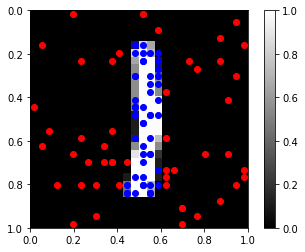

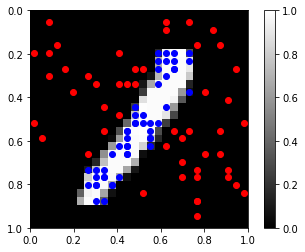

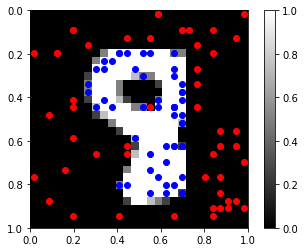

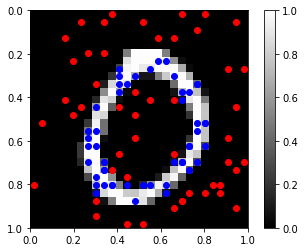

In [10]:
xb = get_batch(X_im_train, X_im_train.shape[0], n=4)
pxi,pyi, pxo, pyo = get_batch_clouds(xb[:,:,:,0], POS_MAT,n=4, n_points=50)

print(xb.shape)
print(pxi.shape)
print(pyi.shape)
print(pxo.shape)
print(pyo.shape)

for i in range(4):
    plt.figure()
    plt.imshow(xb[i,:,:,0], extent=[0, 1, 1, 0], cmap='gray')
    plt.colorbar()
    plt.scatter(pyi[i,:],pxi[i,:], color='b')
    plt.scatter(pyo[i,:],pxo[i,:], color='r')
    plt.show()
    plt.close()

In [11]:
#Define neural network and training parameters
train_steps = 5000
N = X_im_train.shape[0]
Ntest = X_im_test.shape[0]
Nbatch = 8

print_step = 500
W = X_im_train.shape[1]
H = W
C = 1

filters = 16
dims = [5,5]
pool_dims = [2,2]
strides = [1,1]

hidden_size = 100

act = tf.nn.relu

std=1e-2

learning_rate=1e-2
momentum=0.9
l2_coeff = 0.0

n_points = 50
point_dims = 2

hidden_size = n_points*point_dims

In [12]:
#construct input place holders
x     = tf.placeholder(shape=[None, W,H,C],dtype=tf.float32)
y_in  = tf.placeholder(shape=[None, n_points,point_dims],dtype=tf.float32)
y_out = tf.placeholder(shape=[None, n_points,point_dims],dtype=tf.float32)

noise = tf.placeholder(shape=[None, hidden_size], dtype=tf.float32)
#conv layers
o = conv2D(x,dims=dims,nfilters=filters,strides=strides,init=std,
           activation=act, scope='conv_1')

o = tf.nn.pool(o,pool_dims,'MAX',padding='SAME')

o = conv2D(o,dims=dims,nfilters=filters,strides=strides,init=std,
           activation=act, scope='conv_2')

o = tf.nn.pool(o,pool_dims,'MAX', padding='SAME')

o = conv2D(o,dims=dims,nfilters=filters,strides=strides,init=std,
           activation=act, scope='conv_3')

o = tf.nn.pool(o,pool_dims,'MAX', padding='SAME')

#Fully connected layers at end of decoder
s = o.get_shape().as_list()
o = tf.reshape(o,[-1,s[1]*s[2]*s[3]])

o_mu      = fullyConnected(o,hidden_size, scope='dense')

o_log_sig = fullyConnected(o,hidden_size,scope='fc_logits')

#Decoder
z = o_mu + tf.exp(o_log_sig)*noise

d = fullyConnected(o, hidden_size, activation=act, scope='dense_1')

d = fullyConnected(d, hidden_size, activation=act, scope='dense_2')

#out points
d_out = fullyConnected(d,    hidden_size, activation=act, scope='dense_out_1')
d_out = fullyConnected(d_out,hidden_size, activation=tf.nn.sigmoid, scope='dense_out_2')

p_hat_out = tf.reshape(d_out,[-1,n_points,point_dims])

#in points
d_in = fullyConnected(d,   hidden_size, activation=act,           scope='dense_in_1')
d_in = fullyConnected(d_in,hidden_size, activation=tf.nn.sigmoid, scope='dense_in_2')

p_hat_in = tf.reshape(d_in,[-1,n_points,point_dims])

[None, 12544]
[None, 12544]
[None, 12544]
[None, 100]
[None, 100]
[None, 100]
[None, 100]
[None, 100]


In [13]:
p_hat_out_transpose = tf.transpose(p_hat_out, perm=[0,2,1])
p_hat_in_transpose  = tf.transpose(p_hat_in,  perm=[0,2,1])

y_out_transpose = tf.transpose(y_out, perm=[0,2,1])
y_in_transpose  = tf.transpose(y_in,  perm=[0,2,1])

norm_out = tf.matmul(p_hat_out, p_hat_out_transpose)
norm_in  = tf.matmul(p_hat_in,  p_hat_in_transpose)

y_norm_out = tf.matmul(y_out, y_out_transpose)
y_norm_in  = tf.matmul(y_in,  y_in_transpose)

D_out    = tf.matmul(p_hat_out, y_out_transpose)
D_in     = tf.matmul(p_hat_in,  y_in_transpose)

print(norm_out)
print(norm_in)

print(y_norm_out)
print(y_norm_in)

print(D_out)
print(D_in)

Dist_out = norm_out - 2*D_out + y_norm_out
Dist_in  = norm_in  - 2*D_in  + y_norm_in

print(Dist_out)
print(Dist_in)

Loss_vec_out = tf.reduce_min(Dist_out, axis=2)
Loss_vec_in  = tf.reduce_min(Dist_in, axis=2)

loss = tf.reduce_mean(Loss_vec_out+Loss_vec_in)
print(loss)

Tensor("MatMul:0", shape=(?, 50, 50), dtype=float32)
Tensor("MatMul_1:0", shape=(?, 50, 50), dtype=float32)
Tensor("MatMul_2:0", shape=(?, 50, 50), dtype=float32)
Tensor("MatMul_3:0", shape=(?, 50, 50), dtype=float32)
Tensor("MatMul_4:0", shape=(?, 50, 50), dtype=float32)
Tensor("MatMul_5:0", shape=(?, 50, 50), dtype=float32)
Tensor("add_1:0", shape=(?, 50, 50), dtype=float32)
Tensor("add_2:0", shape=(?, 50, 50), dtype=float32)
Tensor("Mean:0", shape=(), dtype=float32)


In [14]:
opt = tf.train.MomentumOptimizer(learning_rate,momentum)
train = opt.minimize(loss)
init = tf.global_variables_initializer()

In [15]:
sess = tf.Session()
sess.run(init)

ResourceExhaustedError: OOM when allocating tensor with shape[100] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[Node: fc_logits/b/Initializer/random_normal/RandomStandardNormal = RandomStandardNormal[T=DT_INT32, _class=["loc:@fc_logits/b/Assign"], dtype=DT_FLOAT, seed=0, seed2=0, _device="/job:localhost/replica:0/task:0/device:GPU:0"](fc_logits/b/Initializer/random_normal/shape)]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.


Caused by op 'fc_logits/b/Initializer/random_normal/RandomStandardNormal', defined at:
  File "/home/marsdenlab/anaconda3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/marsdenlab/anaconda3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/marsdenlab/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/marsdenlab/anaconda3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/marsdenlab/anaconda3/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 486, in start
    self.io_loop.start()
  File "/home/marsdenlab/anaconda3/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 127, in start
    self.asyncio_loop.run_forever()
  File "/home/marsdenlab/anaconda3/lib/python3.6/asyncio/base_events.py", line 422, in run_forever
    self._run_once()
  File "/home/marsdenlab/anaconda3/lib/python3.6/asyncio/base_events.py", line 1432, in _run_once
    handle._run()
  File "/home/marsdenlab/anaconda3/lib/python3.6/asyncio/events.py", line 145, in _run
    self._callback(*self._args)
  File "/home/marsdenlab/anaconda3/lib/python3.6/site-packages/tornado/ioloop.py", line 759, in _run_callback
    ret = callback()
  File "/home/marsdenlab/anaconda3/lib/python3.6/site-packages/tornado/stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/marsdenlab/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 536, in <lambda>
    self.io_loop.add_callback(lambda : self._handle_events(self.socket, 0))
  File "/home/marsdenlab/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 450, in _handle_events
    self._handle_recv()
  File "/home/marsdenlab/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 480, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/marsdenlab/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 432, in _run_callback
    callback(*args, **kwargs)
  File "/home/marsdenlab/anaconda3/lib/python3.6/site-packages/tornado/stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/marsdenlab/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/marsdenlab/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/marsdenlab/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/home/marsdenlab/anaconda3/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/marsdenlab/anaconda3/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/marsdenlab/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2662, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/home/marsdenlab/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2785, in _run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/marsdenlab/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2903, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/marsdenlab/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2963, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-12-67fc5c3fee97>", line 29, in <module>
    o_log_sig = fullyConnected(o,hidden_size,scope='fc_logits')
  File "/home/marsdenlab/projects/point_cloud/modules/layers.py", line 79, in fullyConnected
    b = tf.get_variable("b",shape=shape[1],initializer=tf.random_normal_initializer(0.0,std))
  File "/home/marsdenlab/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/variable_scope.py", line 1328, in get_variable
    constraint=constraint)
  File "/home/marsdenlab/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/variable_scope.py", line 1090, in get_variable
    constraint=constraint)
  File "/home/marsdenlab/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/variable_scope.py", line 435, in get_variable
    constraint=constraint)
  File "/home/marsdenlab/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/variable_scope.py", line 404, in _true_getter
    use_resource=use_resource, constraint=constraint)
  File "/home/marsdenlab/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/variable_scope.py", line 796, in _get_single_variable
    use_resource=use_resource)
  File "/home/marsdenlab/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/variable_scope.py", line 2234, in variable
    use_resource=use_resource)
  File "/home/marsdenlab/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/variable_scope.py", line 2224, in <lambda>
    previous_getter = lambda **kwargs: default_variable_creator(None, **kwargs)
  File "/home/marsdenlab/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/variable_scope.py", line 2207, in default_variable_creator
    constraint=constraint)
  File "/home/marsdenlab/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/variables.py", line 259, in __init__
    constraint=constraint)
  File "/home/marsdenlab/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/variables.py", line 368, in _init_from_args
    initial_value(), name="initial_value", dtype=dtype)
  File "/home/marsdenlab/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/variable_scope.py", line 780, in <lambda>
    shape.as_list(), dtype=dtype, partition_info=partition_info)
  File "/home/marsdenlab/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/init_ops.py", line 293, in __call__
    shape, self.mean, self.stddev, dtype, seed=self.seed)
  File "/home/marsdenlab/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/random_ops.py", line 77, in random_normal
    shape_tensor, dtype, seed=seed1, seed2=seed2)
  File "/home/marsdenlab/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gen_random_ops.py", line 590, in random_standard_normal
    seed2=seed2, name=name)
  File "/home/marsdenlab/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/home/marsdenlab/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 3414, in create_op
    op_def=op_def)
  File "/home/marsdenlab/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1740, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

ResourceExhaustedError (see above for traceback): OOM when allocating tensor with shape[100] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[Node: fc_logits/b/Initializer/random_normal/RandomStandardNormal = RandomStandardNormal[T=DT_INT32, _class=["loc:@fc_logits/b/Assign"], dtype=DT_FLOAT, seed=0, seed2=0, _device="/job:localhost/replica:0/task:0/device:GPU:0"](fc_logits/b/Initializer/random_normal/shape)]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.



In [ ]:
#Start the train loop
train_hist = []
val_hist = []

for i in range(train_steps):
    xb = get_batch(X_im_train, X_im_train.shape[0], n=Nbatch)
    pxi,pyi, pxo, pyo = get_batch_clouds(xb[:,:,:,0], POS_MAT, 
                                         n=Nbatch, n_points=n_points)
    
    P_in = np.concatenate((pxi,pyi), axis=2)
    P_out = np.concatenate((pxo,pyo), axis=2)
    
    eps = np.random.randn(Nbatch,hidden_size)
    
    l,_=sess.run([loss,train],
                 {x:xb, y_in:P_in, y_out:P_out, noise:eps})

    if i%print_step == 0:
        print "iter: {} Train: {}".format(i,l)
        train_hist.append(l)
